# Final project - Bank Churn Binary Classification

### Introduction

The task is to predict whether a customer continues with their account or closes it (e.g., churns). For each id in the test set, we must predict the probability for the target variable Exited.

## Table of Contents

* [1. About the dataset](#chapter1)
    * [1.1. Data import](#section_1_1)
    * [1.2. Size of the dataset](#section_1_2)
    * [1.3. Columns in the dataset](#section_1_3)
        * [1.3.1. Columns description](#sub_section_1_3_1)
        * [1.3.2. Columns overview](#sub_section_1_3_2)
<br><br>     
* [2. Exploratory Data Analysis (EDA)](#chapter2)
    * [2.1. Summary Statistics](#section_2_1)
    * [2.2. Data Visualization](#section_2_2)
        * [2.2.1. Target column](#sub_section_2_2_1)    
        * [2.2.2. Barplot for category columns](#sub_section_2_2_2)
        * [2.2.3. Boxplot for numeric columns](#sub_section_2_2_3)
        * [2.2.4. Distribution of numeric columns](#sub_section_2_2_4)
        * [2.2.5. Correlation analysis](#sub_section_2_2_5)
        * [2.2.6. Distribution of variables in relation to 'Exited'](#sub_section_2_2_6)
    * [2.3. Data Cleaning](#section_2_3)
        * [2.3.1. Missing values](#sub_section_2_3_1)
        * [2.3.2. Duplicates](#sub_section_2_3_2)
    * [2.4. One Hot Encoding](#section_2_4)
    * [2.5. Dimensionality Reduction](#section_2_5)
    * [2.6. Correlation Analysis](#section_2_6)
<br><br>    
* [3. Modeling - XGBoost](#chapter3)
    * [3.1 Basic modeling](#section_3_1)
        * [3.1.1 Balancing classes](#sub_section_3_1_1)
        * [3.1.2 Basic XGBoost classifier without balanced class weights](#sub_section_3_1_2)
        * [3.1.3 Basic XGBoost classifier with balanced class weights](#sub_section_3_1_3)
    * [3.2 Hyperparameters, GridSearch and Cross-Validation modeling](#section_3_2)
        * [3.2.1 Hyperparameters](#sub_section_3_2_1)
        * [3.2.2 Grid Search cross-validation](#sub_section_3_2_2)
    * [3.3 Hyperparameters, GridSearch and Cross-Validation modeling with additional features](#section_3_3)
        * [3.3.1 Feature engineering](#sub_section_3_3_1)
        * [3.3.2 Modeling](#sub_section_3_3_2)
        * [3.3.3 Final model](#sub_section_3_3_3)
        * [3.3.4 Feature importance](#sub_section_3_3_4)


### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import xgboost as xgb
from sklearn.utils import class_weight
from xgboost import XGBClassifier

## 1. About the dataset <a class="anchor" id="chapter1"></a>

### 1.1. Data import <a id="section_1_1"></a>

Train dataset:

In [2]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


Test dataset:

In [3]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


### 1.2. Size of the datasets <a id="section_1_2"></a>

In [4]:
df_train.shape[1]

print(f"Training dataset: \n - number of rows: {df_train.shape[0]} \n - number of columns: {df_train.shape[1]}")

Training dataset: 
 - number of rows: 165034 
 - number of columns: 14


In [5]:
df_test.shape

print(f"Test dataset: \n - number of rows: {df_test.shape[0]} \n - number of columns: {df_test.shape[1]}")

Test dataset: 
 - number of rows: 110023 
 - number of columns: 13


In [6]:
print(f"Ratio test dataset vs. train dataset: {round(df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]),2)}")

Ratio test dataset vs. train dataset: 0.4


### 1.3. Columns in the dataset<a id="section_1_3"></a>

#### 1.3.1. Columns description <a id="sub_section_1_3_1"></a>

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [8]:
print(f"""\033[1m Columns details: \033[0m

• \033[1m{df_train.columns[0]}\033[0m: Row index (int)
• \033[1m{df_train.columns[1]}\033[0m: A unique identifier for each customer (int)
• \033[1m{df_train.columns[2]}\033[0m: Surname of the customer (str)
• \033[1m{df_train.columns[3]}\033[0m: A numerical value representing customer's credit score (int)
• \033[1m{df_train.columns[4]}\033[0m: The country where the customer resides (France, Spain, Germany)
• \033[1m{df_train.columns[5]}\033[0m: Gender of the customer (Male, Female)
• \033[1m{df_train.columns[6]}\033[0m: Age of the customer (float)
• \033[1m{df_train.columns[7]}\033[0m: The number of years the customer has been with the bank (int)
• \033[1m{df_train.columns[8]}\033[0m: Account balance of the customer (float)
• \033[1m{df_train.columns[9]}\033[0m: The number of bank products customer uses (e.g. savings account, credit card) (int 1-4)
• \033[1m{df_train.columns[10]}\033[0m: Whether the customer has a credit card (binary)
• \033[1m{df_train.columns[11]}\033[0m: Whether the customer is an active member (binary)
• \033[1m{df_train.columns[12]}\033[0m: The estimated salary of the customer (float)
• \033[1m{df_train.columns[13]}\033[0m: Whether the customer has churned (binary) - exited = 1 - churn, exited = 0 - remain""")

 Columns details: 

• id: Row index (int)
• CustomerId: A unique identifier for each customer (int)
• Surname: Surname of the customer (str)
• CreditScore: A numerical value representing customer's credit score (int)
• Geography: The country where the customer resides (France, Spain, Germany)
• Gender: Gender of the customer (Male, Female)
• Age: Age of the customer (float)
• Tenure: The number of years the customer has been with the bank (int)
• Balance: Account balance of the customer (float)
• NumOfProducts: The number of bank products customer uses (e.g. savings account, credit card) (int 1-4)
• HasCrCard: Whether the customer has a credit card (binary)
• IsActiveMember: Whether the customer is an active member (binary)
• EstimatedSalary: The estimated salary of the customer (float)
• Exited: Whether the customer has churned (binary) - exited = 1 - churn, exited = 0 - remain


#### 1.3.2. Columns overview <a id="sub_section_1_3_1"></a>

Let's categorize columns in the dataset.

Object type columns:

In [9]:
cat_col = df_train.select_dtypes("object").columns
cat_col

Index(['Surname', 'Geography', 'Gender'], dtype='object')

Columns with limited number of possible values:

In [10]:
df_train.nunique()[df_train.nunique() < 12]

Geography          3
Gender             2
Tenure            11
NumOfProducts      4
HasCrCard          2
IsActiveMember     2
Exited             2
dtype: int64

Columns with many distinct values:

In [11]:
df_train.nunique()[df_train.nunique() >= 12]

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Age                    71
Balance             30075
EstimatedSalary     55298
dtype: int64

After gathering all the information, we can divide columns into three distinct categories:

In [12]:
category_col = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

numeric_col = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

target_col = 'Exited'

We have 4 numeric columns, 6 category columns and 'Exited' is our target variable.

## 2. Exploratory Data Analysis (EDA) <a class="anchor" id="chapter2"></a>

"EDA" stands for Exploratory Data Analysis. It's an approach to analyzing datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods. The primary goal of EDA is to understand the data and its underlying structure, patterns, and relationships, without making any assumptions about causality or hypothesis testing.

### 2.1. Summary Statistics <a id="section_2_1"></a>

In [13]:
df_train.shape

(165034, 14)

In [14]:
df_train.describe().round(2).style.format(precision=2).background_gradient(cmap="Purples")

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00
mean,82516.50,15692005.02,656.45,38.13,5.02,55478.09,1.55,0.75,0.50,112574.82,0.21
std,47641.36,71397.82,80.10,8.87,2.81,62817.66,0.55,0.43,0.50,50292.87,0.41
min,0.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,41258.25,15633141.00,597.00,32.00,3.00,0.00,1.00,1.00,0.00,74637.57,0.00
50%,82516.50,15690169.00,659.00,37.00,5.00,0.00,2.00,1.00,0.00,117948.00,0.00
75%,123774.75,15756824.00,710.00,42.00,7.00,119939.52,2.00,1.00,1.00,155152.47,0.00
max,165033.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


Main observations from the table:
1. **Total Number of Entries**: 
    - The dataset contains 165,034 entries across all columns, as indicated by the count.
<br><br>
2. **Customer ID Range**: 
    - Customer IDs range from 15,565,701 to 15,815,690, suggesting a large customer base within a narrow ID range.
<br><br>
3. **Credit Score**: 
    - The average credit score is 656.45, with a standard deviation of 80.10. The scores range from 350 to 850, showing a wide variability in creditworthiness among customers.
<br><br>
4. **Age Distribution**: 
    - The average age of customers is 38 years, with a standard deviation of 8.87 years. The youngest customer is 18 years old, while the oldest is 92 years old.
<br><br>
5. **Tenure**: 
    - The average tenure with the bank is 5 years, with a standard deviation of 2.81 years. The tenure ranges from 0 to 10 years.
<br><br>
6. **Balance**: 
    - The average account balance is 55,478.09, with a high standard deviation of 62,817.66, indicating significant variation in customer balances. The minimum balance is 0, while the maximum is 250,898.09.
<br><br>
7. **Number of Products**: 
    - On average, customers hold 1.55 products with the bank. The number of products ranges from 1 to 4, with a standard deviation of 0.55.
<br><br>
8. **Credit Card Ownership**: 
    - Approximately 75% of customers have a credit card, as indicated by the mean value of 0.75 for the HasCrCard column.
<br><br>
9. **Activity Status**: 
    - About half of the customers are active members, with a mean value of 0.50 for the IsActiveMember column.
<br><br>
10. **Estimated Salary**: 
    - The average estimated salary is 112,574.82, with a standard deviation of 50,292.87. Salaries range from 11.58 to 199,992.48.
<br><br>
11. **Exited Customers**: 
    - 21% of the customers have exited, as indicated by the mean value of 0.21 for the Exited column.

### 2.2. Data Visualization <a id="section_2_2"></a>

Selected color palette for visualizations:

In [15]:
palette = plt.get_cmap('CMRmap')

colors = [palette(0.3), palette(0.7)]

#### 2.2.1. Target column <a id="sub_section_2_2_1"></a>

Count of classes:

In [16]:
df_train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

Visualization of target variable:

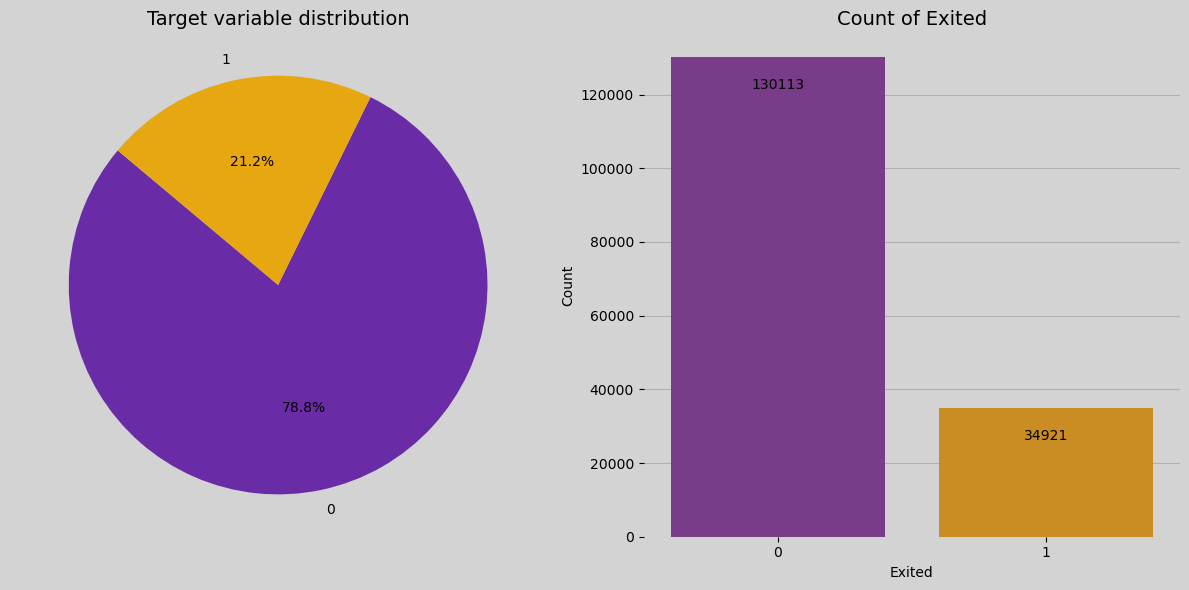

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# background
fig.patch.set_facecolor('lightgrey')

# pie plot
ax1.pie(df_train['Exited'].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, labels=df_train['Exited'].value_counts().index)

# aspect ratio of the plot axes = equal, title
ax1.axis('equal')
ax1.set_title('Target variable distribution', fontsize=14)

# bar plot
sns.countplot(x='Exited', data=df_train, ax=ax2, palette='CMRmap')

# title, axes labels, background 
ax2.set_title('Count of Exited', fontsize=14)
ax2.set_xlabel('Exited')
ax2.set_ylabel('Count')
ax2.set_facecolor('lightgrey')

# frames (non), gridlines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.yaxis.grid(True)
ax2.set_axisbelow(True)

# labels for bar plot
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, -20), 
                 textcoords = 'offset points')
    
plt.tight_layout() # to be sure elements of the plots don't overlap
plt.show()

The target column is highly imbalanced, with 21% of bank customers churning (class 1) and 79% remaining (class 0).

#### 2.2.2. Barplot for category columns <a id="sub_section_2_2_2"></a>

Let's create a DataFrame containing all the categorical columns:

In [18]:
df_train_cat = df_train[category_col]
df_train_cat.head()

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember
0,France,Male,3,2,1.0,0.0
1,France,Male,1,2,1.0,1.0
2,France,Male,10,2,1.0,0.0
3,France,Male,2,1,1.0,1.0
4,Spain,Male,5,2,1.0,1.0


Visualizations:

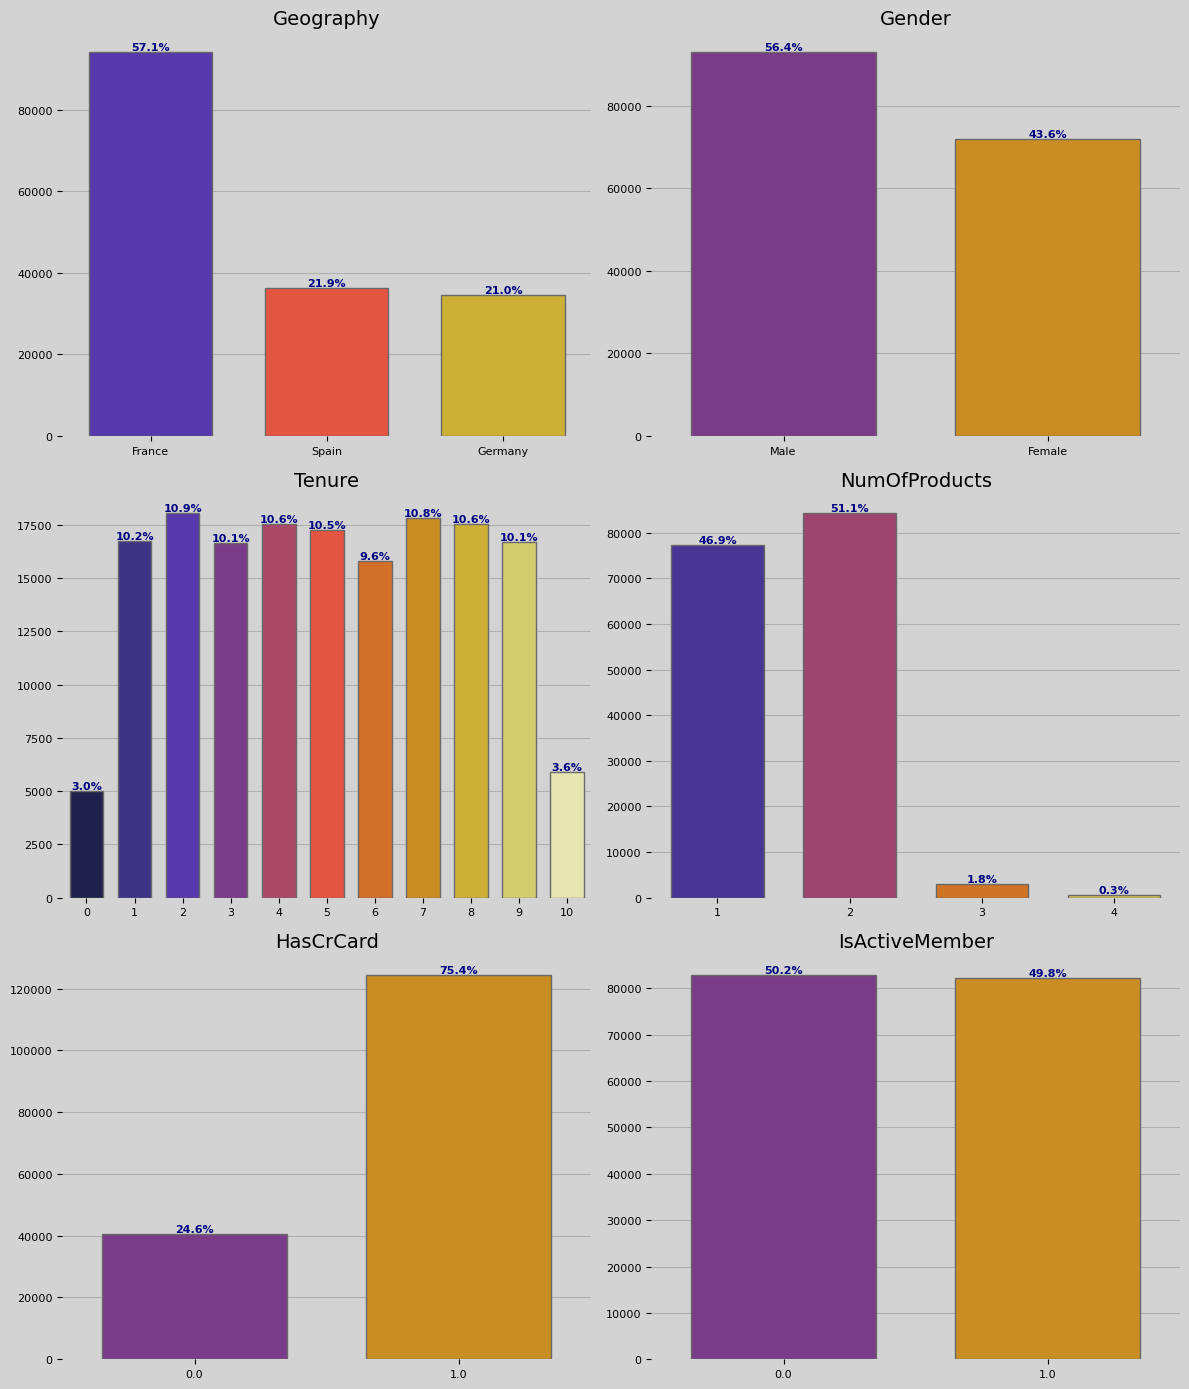

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten() #This line flattens the 2D array of subplot axes into a 1D array, making it easier to iterate over them.

# background
fig.patch.set_facecolor('lightgrey')

for i, column in enumerate(df_train_cat.columns[:6]):
    
    # barplot, title, no axis labels
    sns.countplot(data=df_train_cat, x=column, ax=axes[i], palette='CMRmap', edgecolor='dimgrey', linewidth=1, width=0.7)
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # background of the chart, ticks on both the x-axis and y-axis
    axes[i].set_facecolor('lightgrey')
    axes[i].tick_params(axis='both', which='major', labelsize=8)    
    
    # frames (non), gridlines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.grid(True)
    axes[i].set_axisbelow(True)
    
    # percentage labels
    total = len(df_train_cat[column])
    for p in axes[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i].annotate(percentage, (x, y), ha='center', va='bottom', color='navy', size=8, fontweight='bold')

plt.tight_layout()
plt.show()

Conclutions:
1. **Geography**:
    - The majority of customers are from France (57.1%).
    - Spain and Germany have significantly fewer customers, with 21.9% and 21.0% respectively.
<br><br>
2. **Gender**:
    - There is a higher proportion of male customers (56.4%) compared to female customers (43.6%).
<br><br>
3. **Tenure**:
    - The tenure distribution is relatively even across the range from 1 to 10 years, except for 3.0% for tenure of 0 years and 3.6% for 10 years.
<br><br>
4. **Number of Products**:
    - Most customers have either 1 (46.9%) or 2 (51.1%) products.
    - A very small percentage of customers have 3 or 4 products, at 1.8% and 0.3% respectively.
<br><br>
5. **Credit Card Ownership (HasCrCard)**:
    - A majority of customers (75.4%) have a credit card and 24.6% do not have a credit card.
<br><br>
6. **Active Membership (IsActiveMember)**:
    - The distribution is almost even, with 50.2% of customers being active members and 49.8% not being active members.

#### 2.2.3. Boxplot for numeric columns <a id="sub_section_2_2_3"></a>

Now let's create a DataFrame containing all the numeric columns:

In [20]:
df_train_num = df_train[numeric_col]
df_train_num.head()

,CreditScore,Age,Balance,EstimatedSalary
0,668,33.0,0.00,181449.97
1,627,33.0,0.00,49503.50
2,678,40.0,0.00,184866.69
3,581,34.0,148882.54,84560.88
4,716,33.0,0.00,15068.83


Visualizations:

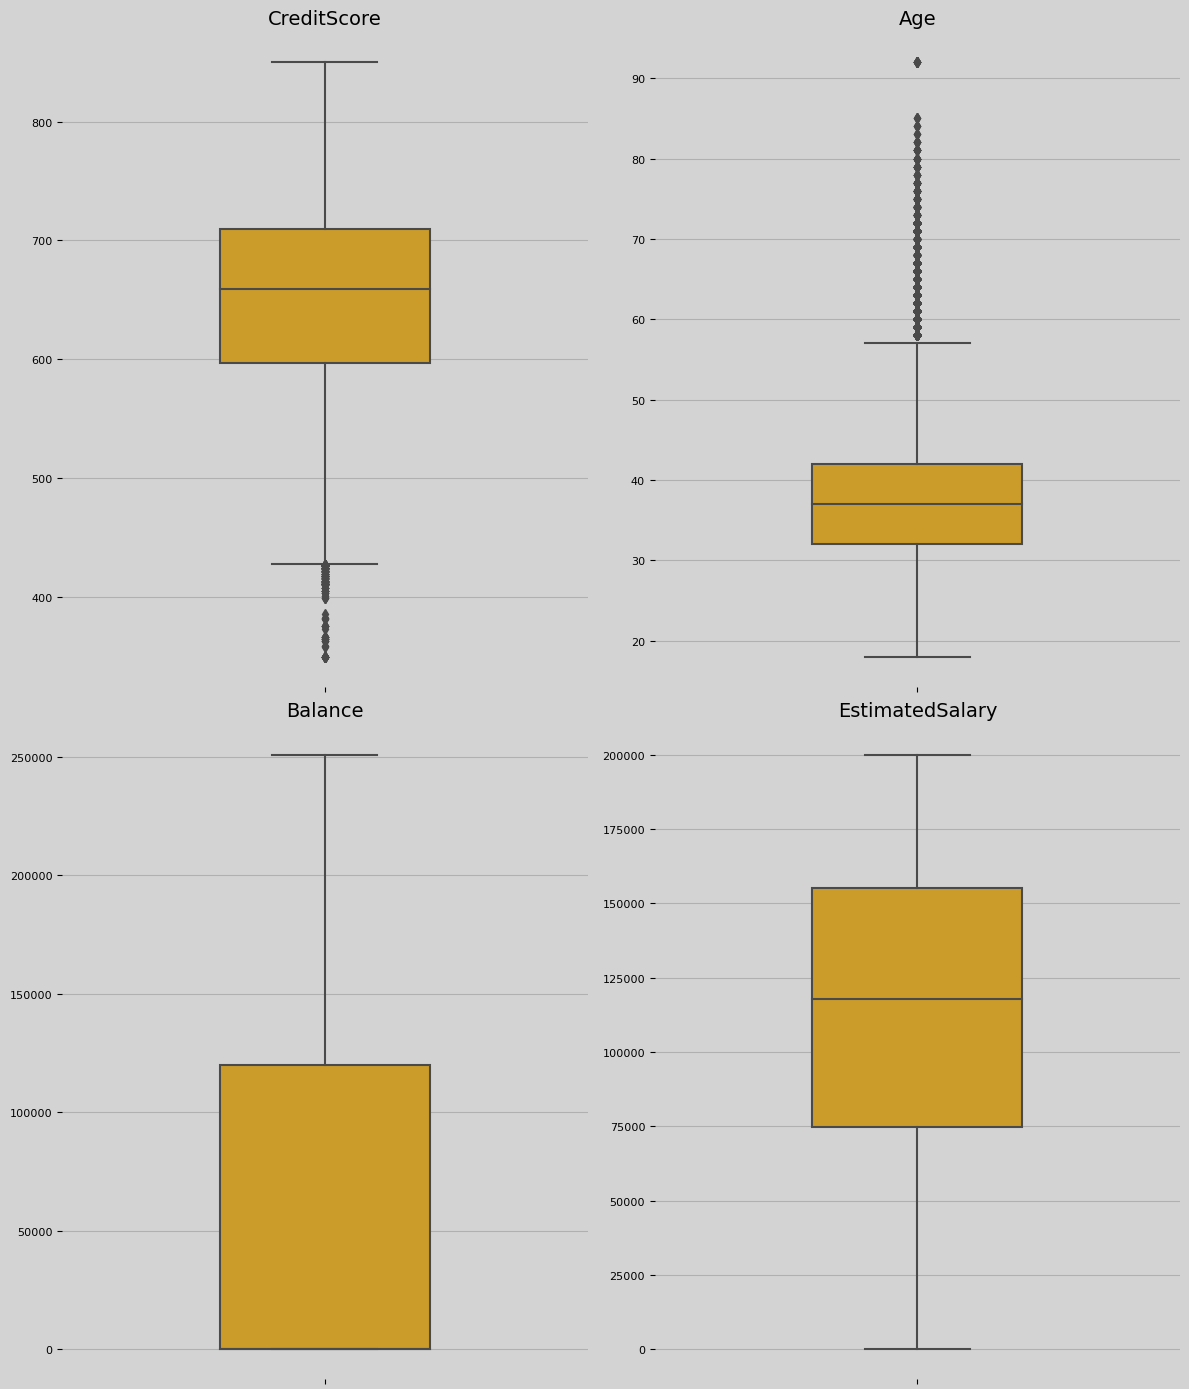

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 14))
axes = axes.flatten()

# background
fig.patch.set_facecolor('lightgrey')

for i, column in enumerate(df_train_num.columns):
    
    # boxplot, title, axes labels
    sns.boxplot(df_train_num[column], ax=axes[i], color=palette(0.7))
    axes[i].set_title(column, fontsize=14)
    axes[i].tick_params(axis='y', which='major', labelsize=8)
    axes[i].set_xticklabels([])
    
    # background of the chart, width of the boxplot
    axes[i].set_facecolor('lightgrey')
    axes[i].set_xlim(-1, 1) 
    
    # frames (non), gridlines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.grid(True)
    axes[i].set_axisbelow(True)

plt.tight_layout()
plt.show()

Main conclusions:
1. **Credit Score**:
    - the majority of credit scores are concentrated between 600 and 720,
    - the outliers in the CreditScore might be genuine low scores rather than errors; we will keep them, as they can provide valuable information about customers with unusually low credit scores.
<br><br>
2. **Age**:
    - the most typical age of the customer oscillates between 30 and 45,
    - there are several outliers above 60, with a single extreme outlier around 90,
    - all the outliers represent older individuals, they are likely valid data points; we will retain them because there is no justification for removing older age groups.
<br><br>
3. **Balance**:
    - the majority of balances range from 0 to around 125,000, with many having zero balance; no significant outliers.
<br><br>
4. **EstimatedSalary**:
    - salaries are widely spread, ranging from 0 to around 200,000, with no significant skew or clustering; no significant outliers.

#### 2.2.4. Distribution of numeric columns <a id="sub_section_2_2_4"></a>

Visualizations:

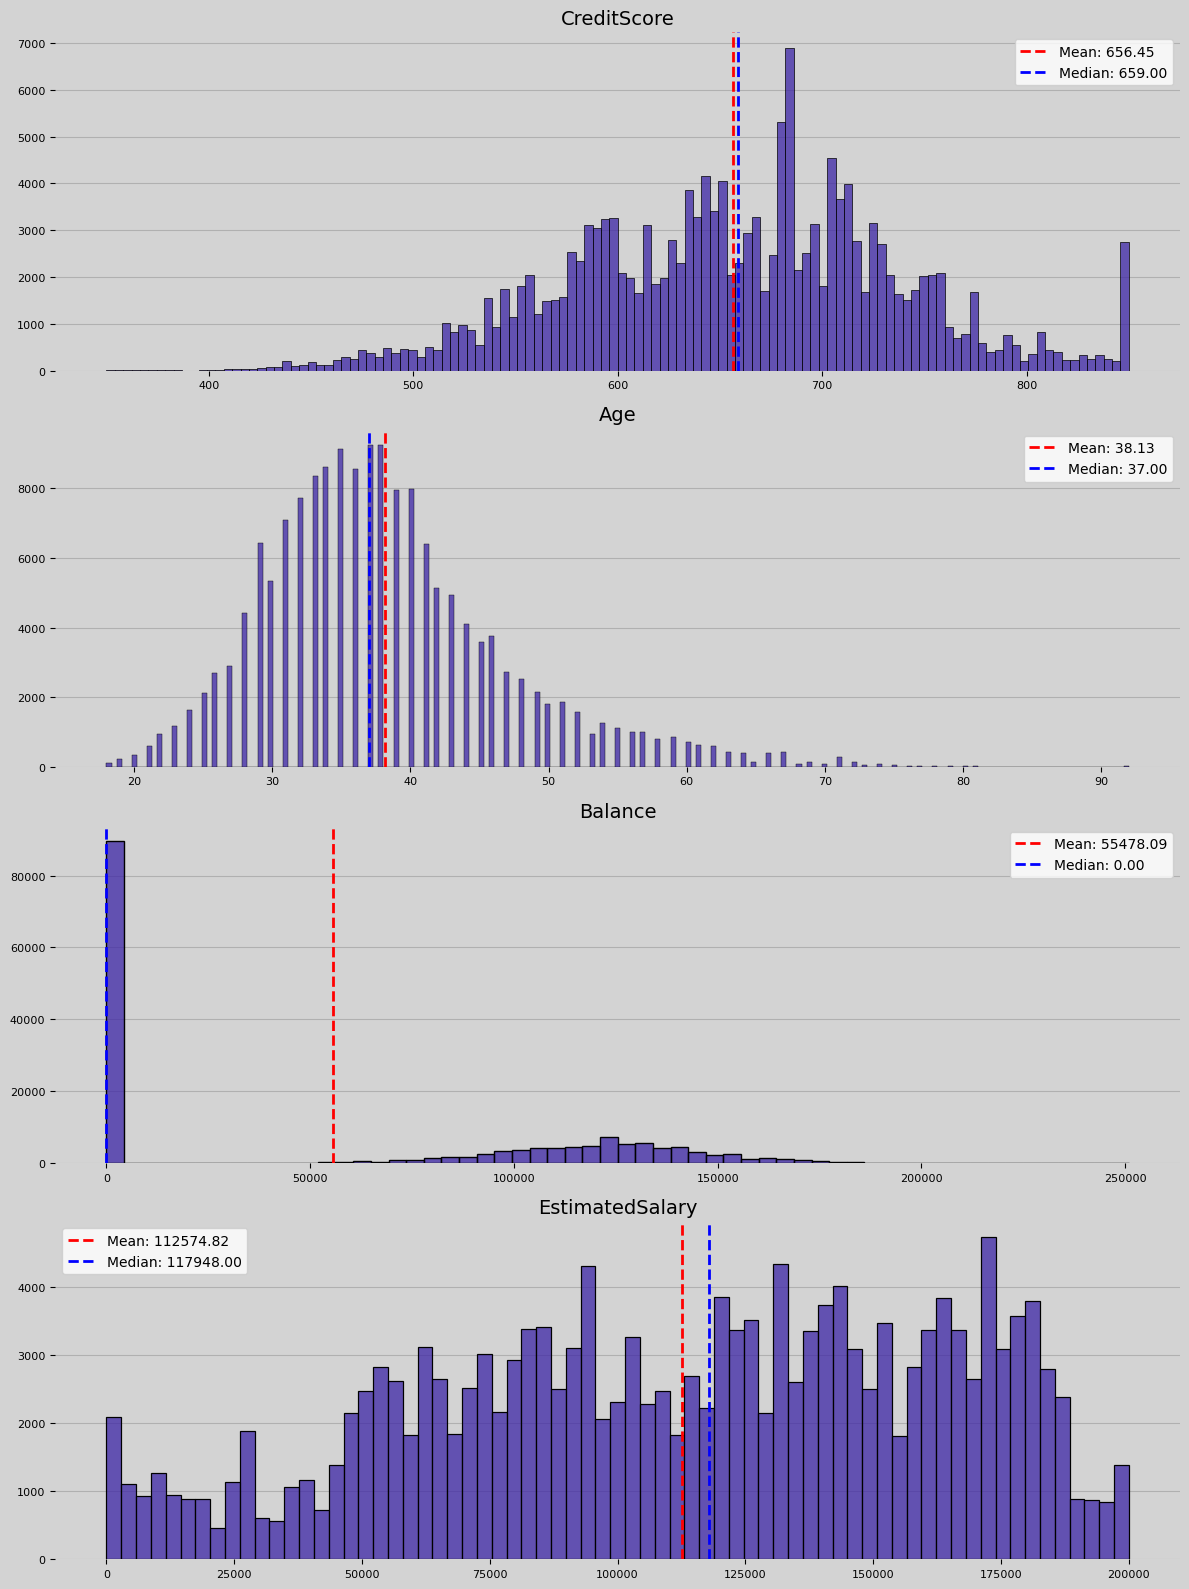

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
axes = axes.flatten()

# background
fig.patch.set_facecolor('lightgrey')

for i, column in enumerate(df_train_num.columns):
    
    # histplot, title, labels, background of the plot
    sns.histplot(data=df_train_num[column], ax=axes[i], color=palette(0.2))
    axes[i].set_title(column, fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    axes[i].set_facecolor('lightgrey')
    
    # no frames, gridlines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.grid(True)
    axes[i].set_axisbelow(True)
    
    # mean line, median line
    axes[i].axvline(df_train_num[column].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df_train_num[column].mean():.2f}')
    axes[i].axvline(df_train_num[column].median(), color='blue', linestyle='dashed', linewidth=2, label=f'Median: {df_train_num[column].median():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Conclusions:

1. **Credit Score**:
    - the mean is 656.45, and the median is 659; this close alignment indicates a fairly symmetrical distribution with slight left skewness,
    - the distribution of CreditScore is relatively normal with no extreme outliers, which suggests that it can be used as-is in the model.
<br><br>
2. **Age**:
    - the Age variable has a distribution skewed to the right, with most customers falling between 30 and 40 years old,
    - the mean is 38.13, and the median is 37, indicating a slight right skew, which indicates a larger number of younger customers.
<br><br>
3. **Balance**:
    - The majority of customers have a zero balance, while a smaller proportion has varying balances, which makes the distribution skewed to 0 side,
    - The mean is 55,478.09, while the median is 0.
<br><br>
4. **EstimatedSalary**:
    - the EstimatedSalary variable appears relatively uniformly distributed, with some minor skewness,
    - the fairly uniform distribution indicates that customers come from various income brackets.

#### 2.2.5. Correlation analysis<a id="sub_section_2_2_5"></a>

**Correlation analysis** - examining the relationships between variables to understand how they influence each other and to identify potential multicollinearity.

Correlation measures the statistical relationship between pairs of columns.

The correlation coefficient ranges from -1 to 1, where:

* 1 indicates a perfect positive correlation (as one variable increases, the other also increases),
* -1 indicates a perfect negative correlation (as one variable increases, the other decreases),
* 0 indicates no correlation.

Let's build correlation matrix:

In [23]:
df_train_cl = df_train[numeric_col + ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']]

# correlation
corr_train = df_train_cl.corr()

mask = np.zeros_like(corr_train) # creates a mask array with the same shape as the corr_train array, filled with zeros
mask[np.triu_indices_from(mask)] = True # modifies the mask array to set all elements in the upper triangle to 1

Visualization:

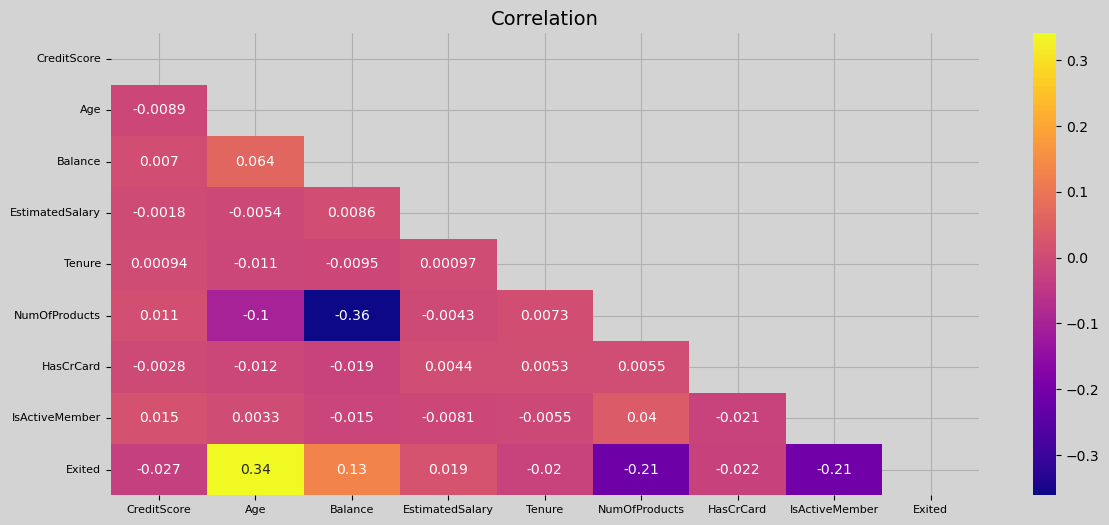

In [24]:
fig, axes = plt.subplots(figsize=(14, 6))

# background
fig.patch.set_facecolor('lightgrey')

# plot
sns.heatmap(corr_train, mask=mask, annot=True, cmap='plasma')

# title, backround of the chart, axes labels, gridlines
plt.title('Correlation', fontsize=14)
plt.gca().set_facecolor('lightgrey') 
plt.tick_params(axis='both', which='major', labelsize=8)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

Main conclusions:
- NumOfProducts has a notable negative correlation with Balance (-0.36), which means customers with more products tend to have lower balances,
- Age has the highest positive correlation with the target variable Exited (0.34), which suggests that older customers are more likely to exit the service,
- Balance also has a positive correlation with Exited (0.13), indicating that customers with higher balances are more likely to exit,
- NumOfProducts and IsActiveMember have a significant negative correlation with Exited (-0.21). This indicates that customers with more products and active members are less likely to exit,
- variables like Age, Balance, NumOfProducts, and IsActiveMember should be considered important features for predicting the Exited variable due to their relatively higher correlations,
- most other variables have weak correlations with each other, indicating that they are relatively independent.

#### 2.2.6. Distribution of variables in relation to 'Exited' <a id="sub_section_2_2_6"></a>

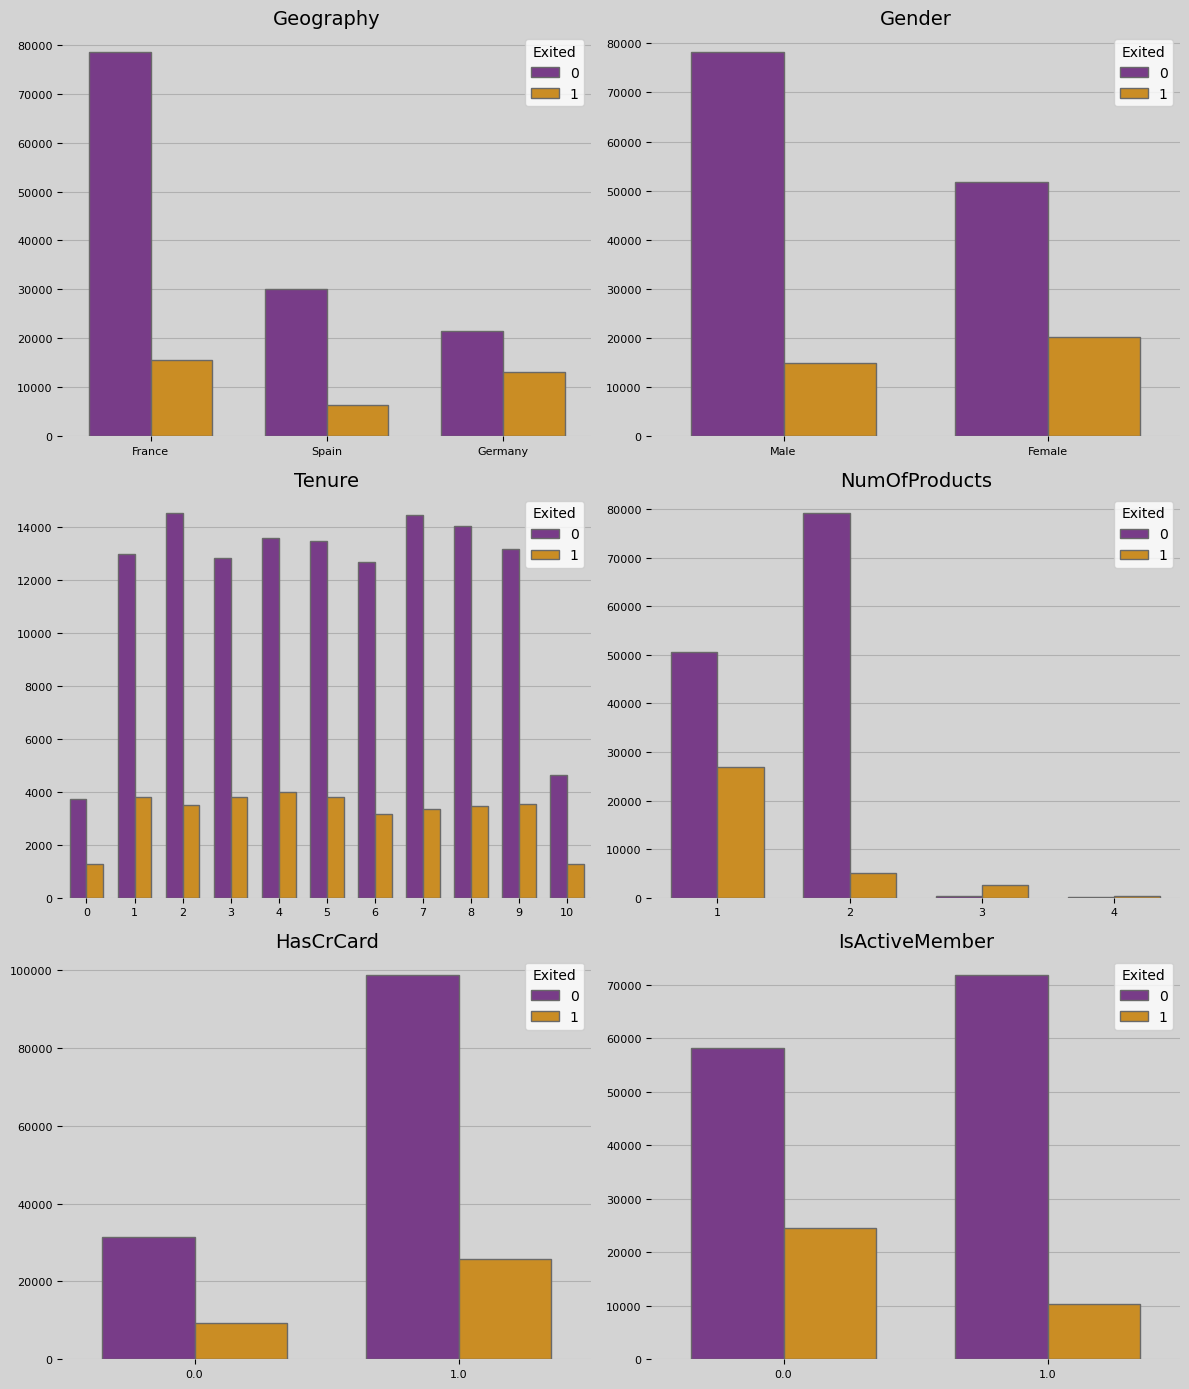

In [25]:
df_train_cat_tg = df_train[category_col + ['Exited']]

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten() 

# background
fig.patch.set_facecolor('lightgrey')

for i, column in enumerate(df_train_cat_tg.columns[:-1]):  # Iterate over the first six columns, excluding 'Exited'
    
    # barplot
    sns.countplot(data=df_train_cat_tg, x=column, hue='Exited', ax=axes[i], palette='CMRmap', edgecolor='dimgrey', linewidth=1, width=0.7)
    
    # title, axes labels, background
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', which='major', labelsize=8)  # Adjusting the tick label font size
    axes[i].set_facecolor('lightgrey')  # Setting background color

    # frames (non), gridlines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.grid(True)
    axes[i].set_axisbelow(True)


plt.tight_layout()
plt.show()

Main conclusions:

1. **Geography**:
    - Germany has a higher proportion of customers who exited compared to France and Spain,
    - geography appears to be a significant factor in customer churn; it will be included in the model, using one-hot encoding to capture the differences among the countries.
<br><br>
2. **Gender**:
    - a higher proportion of female customers have exited compared to male customers,
    - this variable will also be included in the model with encoding for male and female categories.
<br><br>
3. **Tenure**:
    - churn is quite consistent across different tenure values, with a slight increase in churn for customers with very low and very high tenure.
<br><br>
4. **NumOfProducts**:
    - customers with 1 product have a higher churn rate compared to those with 2 products; very few customers with 3 or 4 products have churned.
<br><br>
5. **HasCrCard**:
    - churn rates are similar for customers with and without a credit card.
<br><br>
6. **IsActiveMember**:
    - inactive members have a significantly higher churn rate compared to active members.

### 2.3. Data Cleaning <a id="section_2_3"></a>

#### 2.3.1. Missing values <a id="sub_section_2_3_1"></a>

In [26]:
df_train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [27]:
df_test.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [28]:
print(f"""Number of missing values in train dataset: {df_train.isna().sum().sum()} 
Number of missing values in test dataset: {df_test.isna().sum().sum()} """)

Number of missing values in train dataset: 0 
Number of missing values in test dataset: 0 


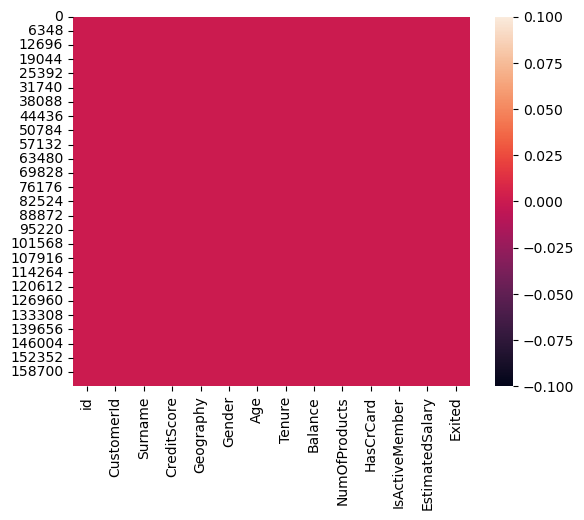

In [29]:
sns.heatmap(df_train.isnull());

#### 2.3.2. Duplicates <a id="sub_section_2_3_2"></a>

In [30]:
print(f"""Number of duplicated rows in train dataset: {df_train.duplicated().sum()} 
Number of duplicated rows in test dataset: {df_test.duplicated().sum()} """)

Number of duplicated rows in train dataset: 0 
Number of duplicated rows in test dataset: 0 


### 2.4. One Hot Encoding<a id="section_2_4"></a>

One-hot encoding is a technique used in machine learning and data preprocessing to represent categorical variables as binary vectors. We convert column Geography and Gender from categorical to binary columns.

Train dataset:

In [31]:
ohe = OneHotEncoder(sparse_output=False)

df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[["Geography", "Gender"]]), columns = ohe.get_feature_names_out())
df_train_ohe

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...
165029,0.0,0.0,1.0,1.0,0.0
165030,1.0,0.0,0.0,0.0,1.0
165031,1.0,0.0,0.0,0.0,1.0
165032,0.0,0.0,1.0,1.0,0.0


Test dataset:

In [32]:
df_test_ohe = pd.DataFrame(ohe.fit_transform(df_test[["Geography", "Gender"]]), columns = ohe.get_feature_names_out())
df_test_ohe

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
110018,0.0,0.0,1.0,0.0,1.0
110019,1.0,0.0,0.0,1.0,0.0
110020,1.0,0.0,0.0,0.0,1.0
110021,1.0,0.0,0.0,1.0,0.0


Let's integrate the one-hot encoded columns with the remaining dataset columns:

In [33]:
df_train_model = pd.concat([df_train.drop(columns = ["Geography", "Gender"]), df_train_ohe], axis=1)
df_train_model

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,0.0,0.0,0.0,1.0
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,0.0,0.0,0.0,1.0
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,0.0,0.0,0.0,1.0
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,0.0,0.0,0.0,1.0
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.0,0.0,1.0,1.0,0.0
165030,165030,15665521,Okechukwu,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0,0.0,0.0,0.0,1.0
165031,165031,15664752,Hsia,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,1.0,0.0,0.0,0.0,1.0
165032,165032,15689614,Hsiung,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.0,0.0,1.0,1.0,0.0


In [34]:
df_test_model = pd.concat([df_test.drop(columns = ["Geography", "Gender"]), df_test_ohe], axis=1)
df_test_model

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,23.0,2,0.00,2,0.0,1.0,160976.75,1.0,0.0,0.0,1.0,0.0
1,165035,15782418,Nott,683,46.0,2,0.00,1,1.0,0.0,72549.27,1.0,0.0,0.0,1.0,0.0
2,165036,15807120,K?,656,34.0,7,0.00,2,1.0,0.0,138882.09,1.0,0.0,0.0,1.0,0.0
3,165037,15808905,O'Donnell,681,36.0,8,0.00,1,1.0,0.0,113931.57,1.0,0.0,0.0,0.0,1.0
4,165038,15607314,Higgins,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0.0,0.0,1.0,0.0,1.0
110019,275053,15774133,Cox,575,36.0,4,178032.53,1,1.0,1.0,42181.68,1.0,0.0,0.0,1.0,0.0
110020,275054,15728456,Ch'iu,712,31.0,2,0.00,2,1.0,0.0,16287.38,1.0,0.0,0.0,0.0,1.0
110021,275055,15687541,Yegorova,709,32.0,3,0.00,1,1.0,1.0,158816.58,1.0,0.0,0.0,1.0,0.0


### 2.5. Dimensionality Reduction <a id="section_2_5"></a>

**Dimensionality reduction** - reducing the number of features or variables in the dataset while preserving its essential information to simplify subsequent analysis.

Let's remove columns 'id', 'CustomerId' and 'Surname' as they do not provide any valuable information about the classes.

In [35]:
df_train_model = df_train_model.drop(["id", "CustomerId", "Surname"], axis=1)
df_train_model.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,0.0,0.0,0.0,1.0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,0.0,0.0,0.0,1.0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,0.0,0.0,0.0,1.0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,0.0,0.0,0.0,1.0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,0.0,1.0,0.0,1.0


In [36]:
df_test_model = df_test_model.drop(["id", "CustomerId", "Surname"], axis=1)
df_test_model.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,586,23.0,2,0.00,2,0.0,1.0,160976.75,1.0,0.0,0.0,1.0,0.0
1,683,46.0,2,0.00,1,1.0,0.0,72549.27,1.0,0.0,0.0,1.0,0.0
2,656,34.0,7,0.00,2,1.0,0.0,138882.09,1.0,0.0,0.0,1.0,0.0
3,681,36.0,8,0.00,1,1.0,0.0,113931.57,1.0,0.0,0.0,0.0,1.0
4,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0.0,1.0,0.0,0.0,1.0


## 3. Modeling - XGBoost <a id="chapter3"></a>

**XGBoost (eXtreme Gradient Boosting)** is a powerful and efficient machine learning algorithm designed for speed and performance. It’s widely used in competitions and real-world applications due to its robustness and flexibility. Here’s a simple overview of XGBoost and how it works:

#### Key Features of XGBoost

1. **Gradient Boosting Framework**:
    - XGBoost is built on the gradient boosting framework. This means it builds models one after another, with each new model fixing errors made by the previous ones.
<br><br>
2. **Regularization**:
    - XGBoost uses L1 (lasso) and L2 (ridge) regularization to prevent overfitting, a common problem in machine learning. Regularization helps the model perform well on new, unseen data.
<br><br>
3. **Parallel Processing**:
    - XGBoost supports parallel processing, which allows it to train models faster by using multiple CPU cores at once. This is especially useful for large datasets.
<br><br>
4. **Tree Pruning**:
    - XGBoost uses advanced tree pruning techniques to stop growing trees when further splits don’t improve the model significantly. This helps prevent overfitting.
<br><br>
5. **Handling Missing Data**:
    - XGBoost can handle missing data without needing to fill in the missing values. This allows the model to learn patterns even when some data is missing.
<br><br>    
6. **Support for Custom Objective Functions**:
    - Users can define their own objective functions and evaluation metrics, making XGBoost flexible for different types of prediction problems.
<br><br>
7. **Efficient Memory Usage**:
    - XGBoost is optimized to use memory efficiently, making it suitable for training on large datasets without needing a lot of computational resources.

#### How XGBoost Works

1. **Initialization**:
    - The process starts with a simple model, like a single node predicting the mean of the target variable for regression or the most common class for classification.
<br><br>
2. **Additive Training**:
    - In each iteration, a new tree is added to the existing set of trees.
    - This new tree is trained to correct the errors (residuals) of the current model.
    - The predictions from the new tree are added to the existing predictions to improve the overall model.
<br><br>
3. **Optimization**:
    - XGBoost uses gradient descent to optimize the loss function, which measures how well the model is doing.
    - In each iteration, it calculates the gradient (the direction and amount of change needed) and updates the model accordingly.
    - It includes a learning rate (eta) to control the size of updates, balancing speed and accuracy.
<br><br>
4. **Regularization and Pruning**:
    - Regularization terms are added to the loss function to penalize overly complex models, helping to prevent overfitting.
    - Tree pruning techniques remove branches that don’t significantly improve the model, reducing complexity and improving generalization.

#### Summary

XGBoost is a highly effective and efficient machine learning algorithm. By building models step-by-step and focusing on correcting errors, it creates powerful predictive models. Its features like regularization, parallel processing, and advanced tree pruning make it suitable for a wide range of tasks, handling large datasets and missing data effectively.

### 3.1. Basic modeling <a id="section_3_1"></a>

In [37]:
X = df_train_model.drop("Exited", axis = 1)
y = df_train_model["Exited"]
X_test = df_test_model

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((99020, 13), (99020,), (66014, 13), (66014,), (110023, 13))

#### 3.1.1. Balancing classes <a id="sub_section_3_1_1"></a> 

It's important thing to mention that both of the classes in our data are highly imbalanced. Almost 80% of our data is from class 0 (not exited) and 20% data is from class 1 (exited).

In [38]:
y_train.value_counts()

Exited
0    78067
1    20953
Name: count, dtype: int64

The class_weight.compute_class_weight function from sklearn.utils.class_weight is used to calculate class weights for imbalanced datasets.
1. The function calculates the number of occurrences of each class in the y_train array.
2. Weight Calculation - ensures that classes with fewer samples get higher weights and classes with more samples get lower weights.

In [39]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

Parameters:
- 'balanced': This strategy calculates the weights inversely proportional to class frequencies in the input data. The goal is to balance the class distribution by assigning a higher weight to the minority class and a lower weight to the majority class.
- classes = np.unique(y_train): This ensures that the function computes weights for all unique classes present in the training data (y_train).
- y = y_train: This is the target array for which the class weights need to be computed.

In [40]:
print(f"Class Weights: {class_weights}")

Class Weights: [0.63419883 2.36290746]


- Weight for class 0: 0.63
- Weight for class 1: 2.36

#### 3.1.2. Basic XGBoost classifier without balanced class weights <a id="sub_section_3_1_2"></a> 

In [42]:
model_unbalanced = XGBClassifier(objective='binary:logistic', random_state=42)

model_unbalanced.fit(X_train, 
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='auc',
        eval_set=[(X_val, y_val)])

y_pred_unbalanced = model_unbalanced.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_unbalanced)

print(classification_report(y_val, y_pred_unbalanced))
print(f"Accuracy: {accuracy:.2f}")

[0]	validation_0-auc:0.87948
[1]	validation_0-auc:0.88265
[2]	validation_0-auc:0.88395
[3]	validation_0-auc:0.88494
[4]	validation_0-auc:0.88553
[5]	validation_0-auc:0.88574


C:\Users\szatk\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\szatk\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.88620
[7]	validation_0-auc:0.88640
[8]	validation_0-auc:0.88643
[9]	validation_0-auc:0.88681
[10]	validation_0-auc:0.88693
[11]	validation_0-auc:0.88698
[12]	validation_0-auc:0.88715
[13]	validation_0-auc:0.88713
[14]	validation_0-auc:0.88705
[15]	validation_0-auc:0.88719
[16]	validation_0-auc:0.88722
[17]	validation_0-auc:0.88713
[18]	validation_0-auc:0.88718
[19]	validation_0-auc:0.88714
[20]	validation_0-auc:0.88720
[21]	validation_0-auc:0.88716
[22]	validation_0-auc:0.88719
[23]	validation_0-auc:0.88720
[24]	validation_0-auc:0.88717
[25]	validation_0-auc:0.88723
[26]	validation_0-auc:0.88724
[27]	validation_0-auc:0.88727
[28]	validation_0-auc:0.88721
[29]	validation_0-auc:0.88709
[30]	validation_0-auc:0.88709
[31]	validation_0-auc:0.88714
[32]	validation_0-auc:0.88713
[33]	validation_0-auc:0.88716
[34]	validation_0-auc:0.88712
[35]	validation_0-auc:0.88707
[36]	validation_0-auc:0.88700
              precision    recall  f1-score   support

           0       

Confusion matrix:

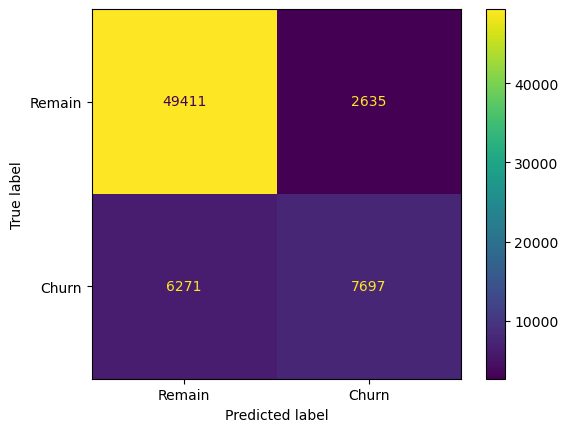

In [43]:
conf_matrix = confusion_matrix(y_val, y_pred_unbalanced)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Remain', 'Churn'])
disp.plot()
plt.show()

Main observations from confusion matrix:
- accuracy in the model shows 87% which is quite good result,
- 49411 clients out of 52046 (95%) who remain with the bank were correctly classified (exited=0),
- 7697 client out of 13968 (55%) who left the bank were correctly classified which is very poor result (exited=1)
- if we are focusing in our model on customers we are able to keep percent of recall (95%) gives us high percent of fit

#### 3.1.3. Basic XGBoost classifier with balanced class weights <a id="sub_section_3_1_3"></a> 

In [45]:
model_balanced = XGBClassifier(objective='binary:logistic', random_state=42)

model_balanced.fit(X_train,
        y_train,
        sample_weight=class_weights[y_train],
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='auc',
        eval_set=[(X_val, y_val)])

y_pred_balanced = model_balanced.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_balanced)

print(classification_report(y_val, y_pred_balanced))

print(f"Accuracy: {accuracy:.2f}")

[0]	validation_0-auc:0.87977
[1]	validation_0-auc:0.88236
[2]	validation_0-auc:0.88442
[3]	validation_0-auc:0.88472
[4]	validation_0-auc:0.88561


C:\Users\szatk\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\szatk\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.88602
[6]	validation_0-auc:0.88644
[7]	validation_0-auc:0.88668
[8]	validation_0-auc:0.88676
[9]	validation_0-auc:0.88682
[10]	validation_0-auc:0.88686
[11]	validation_0-auc:0.88702
[12]	validation_0-auc:0.88722
[13]	validation_0-auc:0.88733
[14]	validation_0-auc:0.88749
[15]	validation_0-auc:0.88752
[16]	validation_0-auc:0.88746
[17]	validation_0-auc:0.88747
[18]	validation_0-auc:0.88751
[19]	validation_0-auc:0.88759
[20]	validation_0-auc:0.88766
[21]	validation_0-auc:0.88750
[22]	validation_0-auc:0.88750
[23]	validation_0-auc:0.88745
[24]	validation_0-auc:0.88741
[25]	validation_0-auc:0.88742
[26]	validation_0-auc:0.88746
[27]	validation_0-auc:0.88748
[28]	validation_0-auc:0.88748
[29]	validation_0-auc:0.88749
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     52046
           1       0.55      0.79      0.64     13968

    accuracy                           0.82     66014
   macro avg       0.74      0.81    

Confusion matrix:

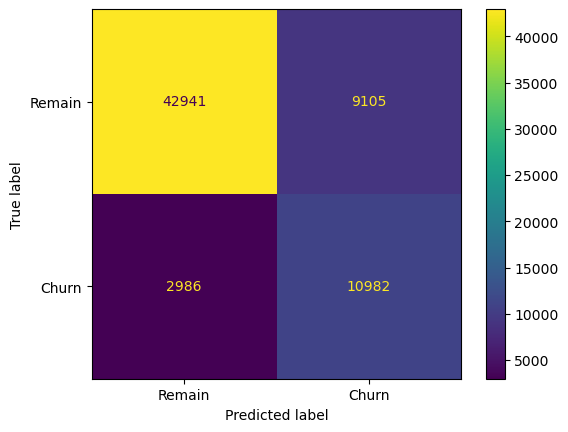

In [46]:
conf_matrix = confusion_matrix(y_val, y_pred_balanced)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Remain', 'Churn'])
disp.plot()
plt.show()

Main observations from confusion matrix:
- accuracy in the model decreased to 82% comparing to not balanced model,
- 42941 clients out of 52046 (82.5%) who remain with the bank were correctly classified (exited=0),
- 10982 client out of 13968 (79%) who left the bank were correctly classified which is very poor result (exited=1),
- in this case class 1 is much more balanced (79%) so if we are focused on the churn customers it is better to choose this version of model, however if we are focusing on customers who can stay first model is better (95% > 82.5%)

### 3.2. Hyperparameters, GridSearch and Cross-Validation modeling <a id="section_3_2"></a>

#### 3.2.1. Hyperparameters <a id="sub_section_3_2_1"></a>

Let's take unbalanced model as a base.
In XGBoost Hyperparameter scale_pos_weight helps to deal with the imbalanced data.

**Booster Parameters in XGBoost used in our model** - these parameters control the training algorithm itself, such as the type of booster (gbtree or gblinear), maximum tree depth (max_depth), learning rate (learning_rate or eta), etc., they directly affect the construction and updating of the model during training:
- **n_estimators**:
    - specifies the number of boosting rounds or the number of trees to be built,
    - it's one of the key parameters in XGBoost and plays a crucial role in determining the performance and complexity of the model,
    - it significantly impacts model performance, complexity, and training time,
    - finding the right balance for n_estimators is crucial and often involves tuning with cross-validation,
<br>  
<br>    
- **eta (learning_rate)** [default=0.3]:
    - it is the step size shrinkage used in update to prevent overfitting, 
    - after each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative (High Threshold for Positive Predictions, Low False Positive Rate (FPR), Higher False Negative Rate (FNR), High Precision, Lower Recall),
    - it makes the model more robust by shrinking the weights on each step,
    - range: [0, 1],
    - typical final values : 0.01-0.2,
<br>  
<br>
- **gamma (min_split_loss)** [default=0]:
    - gamma specifies the minimum loss reduction required to make a split,
    - it makes the algorithm conservative, the values can vary depending on the loss function and should be tuned,
    - the larger gamma is, the more conservative the algorithm will be,
<br>  
<br>
- **max_depth** [default=6]: 
    - the maximum depth of a tree,
    - increasing the value will make the model more complex and more likely to overfit,
    - we should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree,
<br>  
<br>
- **lambda (reg_lambda)** [default=1]:
    - L2 regularization term on weights,
    - this is used to handle the regularization part of XGBoost,
    - increasing this value will make model more conservative,
<br>  
<br>
- **scale_pos_weight** [default=1]: 
    - it controls the balance of positive and negative weights, 
    - **helps to deal with the imbalanced data**, 
    - value greater than 0 should be used in case of high class imbalance as it helps in faster convergence,
    - typical value to consider: sum(negative instances) / sum(positive instances)
<br>  
<br> 

**Learning Task Parameters in XGBoost** - these parameters control the overall behavior of the training process, such as the evaluation metrics, stopping criteria, and other high-level training configurations, They manage how the training process should be executed rather than the specifics of how each model (booster) should be built:
- **objective**: it defines the loss function to be minimized
    - *binary:logistic* : logistic regression for binary classification, output probability (most popular),
<br>  
<br>     
- **early_stopping_rounds**:
    - used to stop the training process early if the performance on a validation set does not improve for a specified number of rounds,
<br>  
<br> 
- **eval_metric**: 
    - the metric to be used for validation data,
    - the default values are *rmse for regression*, *error for classification* and *mean average precision for ranking*,
    - we can add multiple evaluation metrics

In [47]:
fixed_params = {
    'objective': 'binary:logistic',
    'early_stopping_rounds': 20,
    'eval_metric': 'auc'
}

grid_params = {
    'n_estimators': [160, 170, 180],
    'max_depth': [3, 4, 5],
    'learning_rate': [0, 0.1, 0.2],
    'gamma': [0.1, 0.2, 0.3],
    'reg_lambda': [10, 15, 20],
    'scale_pos_weight': [0, 1, 2]
}

In [48]:
model = XGBClassifier(**fixed_params, use_label_encoder=False, random_state=42)

#### 3.2.2. Grid Search cross-validation<a id="sub_section_3_2_2"></a>

**GridSearchCV** is a tool provided by the scikit-learn library in Python for performing hyperparameter tuning. It systematically works through multiple combinations of parameter values, cross-validates each combination, and selects the set of parameters that gives the best performance.
- **Systematic Search**: 
    - GridSearchCV exhaustively searches over a specified parameter grid to find the optimal hyperparameters for a given model.
<br>  
<br> 
- **Cross-Validation**:
    - For each combination of hyperparameters, GridSearchCV performs k-fold cross-validation to evaluate the model's performance. This helps ensure that the model's performance is not overly dependent on the specific train-test split.
<br>  
<br> 
- **Performance Metric**: 
    - The performance of each combination of hyperparameters is evaluated using a specified scoring metric, such as accuracy, precision, recall, F1 score, or ROC-AUC.

Main parameters in the GridSearch:

- The **scoring** parameter determines the metric used to evaluate the performance of the model during the grid search.
- The **cv** parameter determines the cross-validation splitting strategy used during the grid search.
- The **verbose** parameter controls the level of verbosity (i.e., the amount of information displayed) during the grid search:
    - A higher number indicates more detailed output. For example:
    - verbose=0: No output (silent mode).
    - verbose=1: Display a limited amount of information, such as the progress of the grid search (e.g., which parameter combination is currently being evaluated).
    - verbose=2 or higher: More detailed information, including the score of each fold and combination.
- The **'n_jobs'** parameter is to control the parallelism of the grid search, allowing multiple computations to be performed simultaneously. n_jobs can be set to various values to control the level of parallelism:
    - n_jobs=None or n_jobs=1: The computation is run on a single CPU core (no parallelism).
    - n_jobs=-1: The computation is run on all available CPU cores, maximizing parallelism and potentially speeding up the grid search significantly.
    - n_jobs=n: Where n is an integer greater than 1, specifying the number of CPU cores to use.

We're defining GridSearchCV object:

In [49]:
grid_search = GridSearchCV(
    estimator = model,
    param_grid = grid_params,
    scoring = 'roc_auc',
    cv = 5,
    verbose = 1,
    n_jobs=-1
)

and fitting the model

In [51]:
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=20,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.1, 0.2, 0.3],
                         'learning_rate': [0, 0.1, 0.2], 'max_depth': [3, 4, 5],
                         'n_estimators': [160, 170, 180],
                         'reg_lambda': [10, 15, 20],
                         'scale_pos_weight': [0, 1, 2]},
             scoring='roc_auc', verbose=1)

Get the best parameters:

In [52]:
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 170, 'reg_lambda': 15, 'scale_pos_weight': 1}


In [53]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     52046
           1       0.75      0.55      0.63     13968

    accuracy                           0.87     66014
   macro avg       0.82      0.75      0.78     66014
weighted avg       0.86      0.87      0.86     66014

Accuracy: 0.87


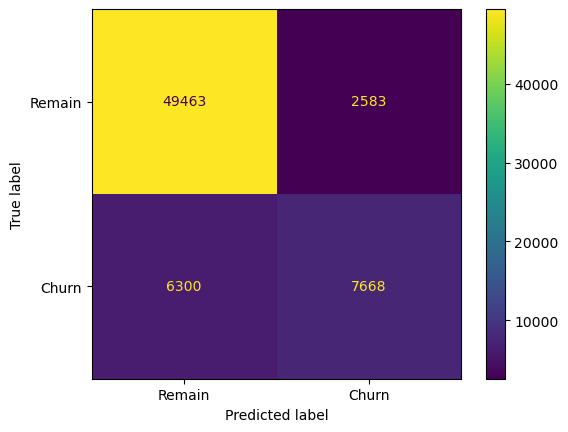

In [54]:
conf_matrix = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Remain', 'Churn'])
disp.plot()
plt.show()

The model selected by GridSearch is similar to the first one, meaning the core algorithm and its parameters haven't changed drastically. Instead, minor adjustments have been made to better handle the class imbalance.

- **Slightly better balance of remain customers**: The new model has fewer false positive and more true positives.
<br><br>
- **Marginal gains**: The improvement might be minor due to the similarity in model structure and features used. This suggests the original model was already quite effective, and further gains are challenging without more significant changes.

### 3.3. Hyperparameters, GridSearch and Cross-Validation modeling with additional features <a id="section_3_3"></a>

#### 3.3.1. Feature engineering <a id="sub_section_3_3_1"></a>

To potentially improve the performance of machine learning models, we can create new features. Let's:

- separate customers with no balance with customers with positive balance:

In [136]:
df_train_model['IsBalance'] = pd.cut(df_train_model['Balance'], 
                                     bins=[-float('inf'), 0, float('inf')], 
                                     labels=[0, 1])
df_train_model['IsBalance'] = pd.to_numeric(df_train_model['IsBalance'])

- create age groups to capture different life stages:

In [138]:
df_train_model['Age_Group'] = pd.cut(df_train_model['Age'], 
                                     bins=[18, 30, 40, 50, 60, 100], 
                                     labels=[1, 2, 3, 4, 5])
df_train_model['Age_Group'] = pd.to_numeric(df_train_model['Age_Group'])

- create a new feature that combines Geography and Gender. This could capture any interaction effects between these variables:

In [139]:
df_train_model['France_Male'] = df_train_model['Geography_France'] * df_train_model['Gender_Male']
df_train_model['Germany_Male'] = df_train_model['Geography_Germany'] * df_train_model['Gender_Male']
df_train_model['Spain_Male'] = df_train_model['Geography_Spain'] * df_train_model['Gender_Male']
df_train_model['France_Female'] = df_train_model['Geography_France'] * df_train_model['Gender_Female']
df_train_model['Germany_Female'] = df_train_model['Geography_Germany'] * df_train_model['Gender_Female']
df_train_model['Spain_Female'] = df_train_model['Geography_Spain'] * df_train_model['Gender_Female']

- examine the interaction feature between NumOfProducts and IsActiveMember to capture any combined effects:

In [140]:
df_train_model['NumOfProducts_if_Active'] = df_train_model['NumOfProducts'] * df_train_model['IsActiveMember']

- combine HasCrCard and IsActiveMember to capture any interaction between having a credit card and being an active member:

In [141]:
df_train_model['CrCard_IsActive'] = df_train_model['HasCrCard'] * df_train_model['IsActiveMember']

- create a ratio feature of Balance to EstimatedSalary to understand financial stability:

In [142]:
df_train_model['Balance/Salary'] = df_train_model['Balance'] / df_train_model['EstimatedSalary']

- create an interaction feature between CreditScore and Age:

In [143]:
df_train_model['Credit_vs_Age'] = df_train_model['CreditScore'] * df_train_model['Age']

In [62]:
df_train_model.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,...,France_Male,Germany_Male,Spain_Male,France_Female,Germany_Female,Spain_Female,NumOfProducts_if_Active,CrCard_IsActive,Balance/Salary,Credit_vs_Age
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,22044.0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.000000,20691.0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,27120.0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.760655,19754.0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.000000,23628.0


In [63]:
y

0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

#### 3.2.2. Modeling <a id="sub_section_3_3_2"></a>

In [96]:
X = df_train_model.drop("Exited", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((99020, 25), (99020,), (66014, 25), (66014,), (110023, 13))

In [126]:
fixed_params2 = {
    'objective': 'binary:logistic',
    'early_stopping_rounds': 20,
    'eval_metric': 'auc'
}

grid_params2 = {
    'n_estimators': [210, 220, 230],
    'max_depth': [3, 4, 5],
    'learning_rate': [0, 0.1, 0.2],
    'gamma': [0.4, 0.5, 0.6],
    'reg_lambda': [17, 18, 19],
    'scale_pos_weight': [0, 1, 2]
}

In [127]:
model2 = XGBClassifier(**fixed_params2, use_label_encoder=False, random_state=42)

In [128]:
grid_search2 = GridSearchCV(
    estimator = model2,
    param_grid = grid_params2,
    scoring = 'roc_auc',
    cv = 5,
    verbose = 1
)

In [129]:
grid_search2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=20,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0.4, 0.5, 0.6],
                         'learning_rate': [0, 0.1, 0.2], 'max_depth': [3, 4, 5],
                         'n_estimators': [210, 220, 230],
                         'reg_lambda': [17, 18, 19],
                         'scale_pos_weight': [0, 1, 2]},
             scoring='roc_auc', verbose=1)

In [130]:
best_params2 = grid_search2.best_params_
print(f"Best hyperparameters: {best_params2}")

Best hyperparameters: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 210, 'reg_lambda': 18, 'scale_pos_weight': 1}


In [131]:
best_model2 = grid_search2.best_estimator_

y_pred2 = best_model2.predict(X_val)

accuracy2 = accuracy_score(y_val, y_pred2)

print(classification_report(y_val, y_pred2))

print(f"Accuracy: {accuracy2:.2f}")

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     52046
           1       0.75      0.55      0.63     13968

    accuracy                           0.87     66014
   macro avg       0.82      0.75      0.78     66014
weighted avg       0.86      0.87      0.86     66014

Accuracy: 0.87


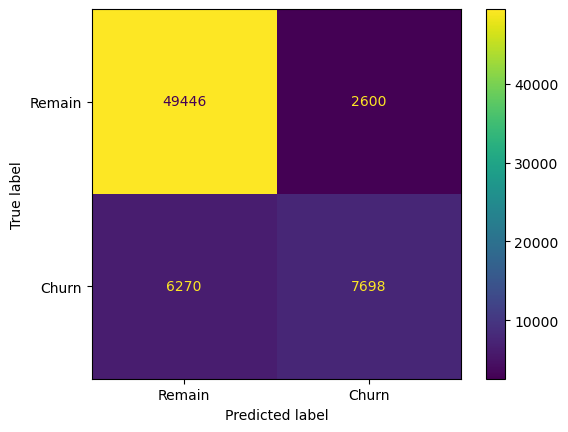

In [132]:
conf_matrix2 = confusion_matrix(y_val, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2, display_labels=['Remain', 'Churn'])
disp.plot()
plt.show()

Additional features didn't improve the performance of the model.

#### 3.3.3. Final model <a id="sub_section_3_3_3"></a>

Let's drop additional features as they didn't improve the model:

In [144]:
df_train_model.drop(['IsBalance', 'Age_Group', 'France_Male', 'Germany_Male', 'Spain_Male', 'France_Female', 'Germany_Female', 'Spain_Female', 'NumOfProducts_if_Active', 'CrCard_IsActive', 'Balance/Salary', 'Credit_vs_Age'], axis=1, inplace=True)

In [145]:
df_train_model.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,0.0,0.0,0.0,1.0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,0.0,0.0,0.0,1.0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,0.0,0.0,0.0,1.0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,0.0,0.0,0.0,1.0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,0.0,1.0,0.0,1.0


Final model based on best parameters from GridSearchCV:

In [146]:
X = df_train_model.drop("Exited", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [147]:
final_model = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=0.2,
                               learning_rate=0.1,
                               max_depth=4,
                               reg_lambda=15,
                               scale_pos_weight=1,
                               n_estimators=170)

final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

y_pred = final_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     52046
           1       0.75      0.55      0.63     13968

    accuracy                           0.87     66014
   macro avg       0.82      0.75      0.78     66014
weighted avg       0.86      0.87      0.86     66014

Accuracy: 0.87


#### 3.3.4. Feature importance <a id="sub_section_3_3_4"></a>

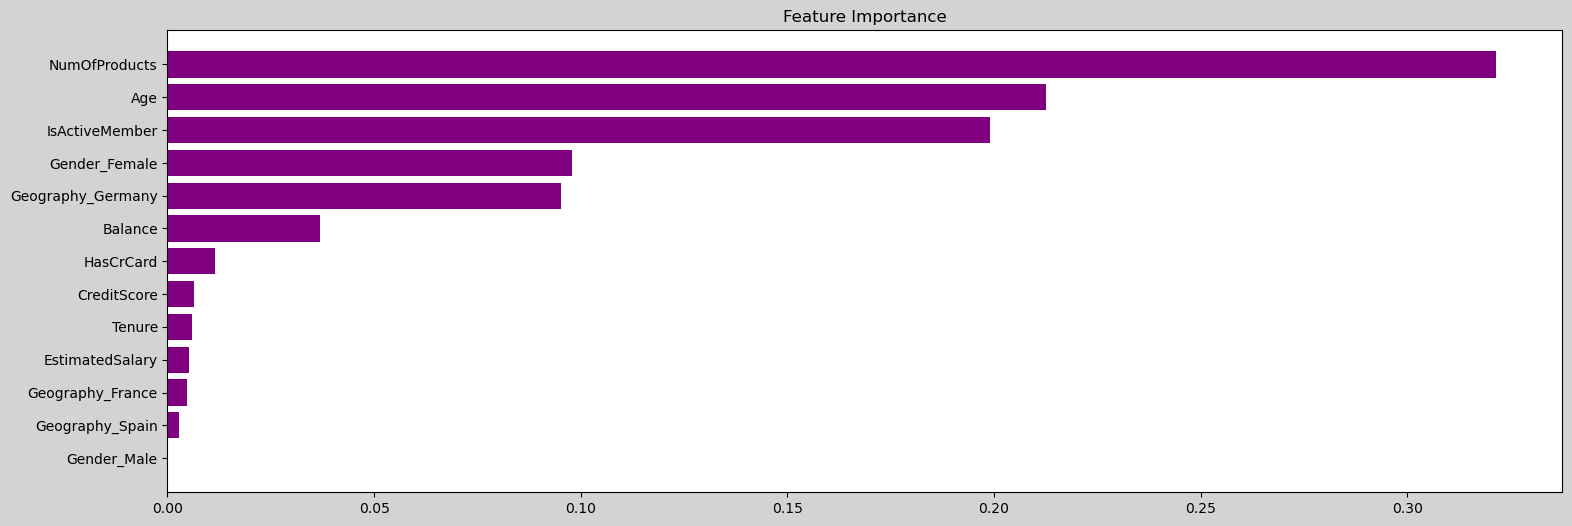

In [148]:
feature_importance = final_model.feature_importances_
sorted_features = np.argsort(feature_importance)

fig = plt.figure(figsize=(18, 6))
fig.patch.set_facecolor('lightgrey')

plt.barh(range(len(sorted_features)), feature_importance[sorted_features], align='center', color='purple')
plt.yticks(range(len(sorted_features)), np.array(X_val.columns)[sorted_features])
plt.title('Feature Importance')
plt.show()

3 Key Insights from the Feature Importance Chart

- **NumOfProducts is the most influential feature**:
Customers with more products are less likely to churn, making the number of products a key predictor of customer retention.
<br><br>
- **Age and IsActiveMember are highly significant**:
Older customers and those who are active members are less likely to churn, highlighting the importance of age and engagement in retaining customers.
<br><br>
- **Geographical and Gender factors vary in importance**:
Customers from Germany and females show distinct retention patterns, while those from Spain, France, and males have a less significant impact on churn predictions, indicating varied churn behavior across different demographics.

### **Final prediction on the test data**:

In [149]:
y_test = final_model.predict_proba(X_test)[:, 1]
y_test

array([0.02901208, 0.7778719 , 0.02918848, ..., 0.01552246, 0.16907522,
       0.19006449], dtype=float32)